In [1]:
from ebmdatalab.bq import cached_read
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
vendors = pd.read_csv('vendors.csv')
# Clean up the input data
vendors['Principal Supplier'] = vendors['Principal Supplier'].str.strip()
vendors.loc[vendors['Principal Supplier'] == 'INPS', 'Principal Supplier'] = 'Vision'  # seems they changed in 2017
vendors = vendors.loc[vendors['Date'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this

start = pd.to_datetime('2016-01-01')
mid = pd.to_datetime('2017-01-01')
end = pd.to_datetime('2018-12-01')

In [89]:
from ebmdatalab import bq
import importlib
importlib.reload(bq)
measures = ['diltiazem']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.practice_id,
  m.pct_id,
  m.month,
  numerator,
  denominator,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND practices.status_code = 'A'
  AND denominator > 0
ORDER BY
  month""".format(measure_id=measure_id)
    import pandas as pd
    df = bq.cached_read(sql, csv_path="data/diltiazem.csv.zip".format(measure_id))
    return df


df = get_data('diltiazem')

In [90]:
df['calc_value'] = df['numerator'] / df['denominator']
df['month'] = pd.to_datetime(df['month'])

Text(0.5, 1.0, 'diltiazem measure, mean values per supplier')

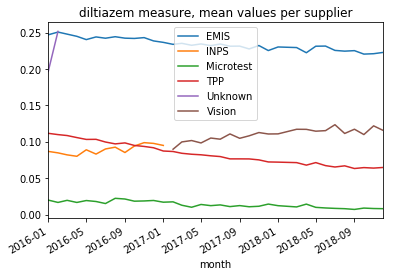

In [5]:
df.groupby(['month', 'supplier']).mean()['calc_value'].unstack().plot.line()
plt.legend(loc='best')
plt.title("diltiazem measure, mean values per supplier")

In [147]:
df.rename(columns={'pct_id':'pct'}, inplace=True)  # The CCG column must be named 'pct' for the maps function
by_pct = df[df['month'] == end].groupby('pct').sum().reset_index()
by_pct['calc_value'] = by_pct['numerator'] / by_pct['denominator']
by_supplier_and_pct = df.groupby(['supplier', 'pct']).sum().reset_index()
by_supplier_and_pct['calc_value'] = by_supplier_and_pct['numerator'] / by_supplier_and_pct['denominator']

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


NameError: name 'by_pct' is not defined

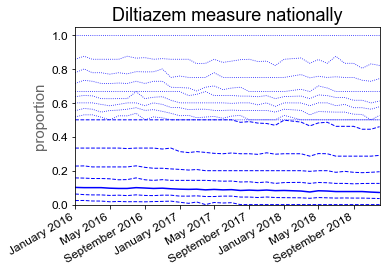

In [103]:
from ebmdatalab import charts
import matplotlib.gridspec as gridspec
from ebmdatalab import maps
import importlib
importlib.reload(maps)

plt.figure(figsize=(12,8))
layout = gridspec.GridSpec(2, 2)
left_ax = plt.subplot(layout[0, 0])
right_subplot = layout[0:2, 1]



charts.deciles_chart(
        df,
        period_column='month',
        column='calc_value',
        title="Diltiazem measure nationally",
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=False,
    ax=left_ax
    )
maps.ccg_map(by_pct, title="Diltiazem measure (all suppliers)", 
             column='calc_value', cartogram=True,
             show_legend=False,
             subplot_spec=right_subplot)

plt.show()

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


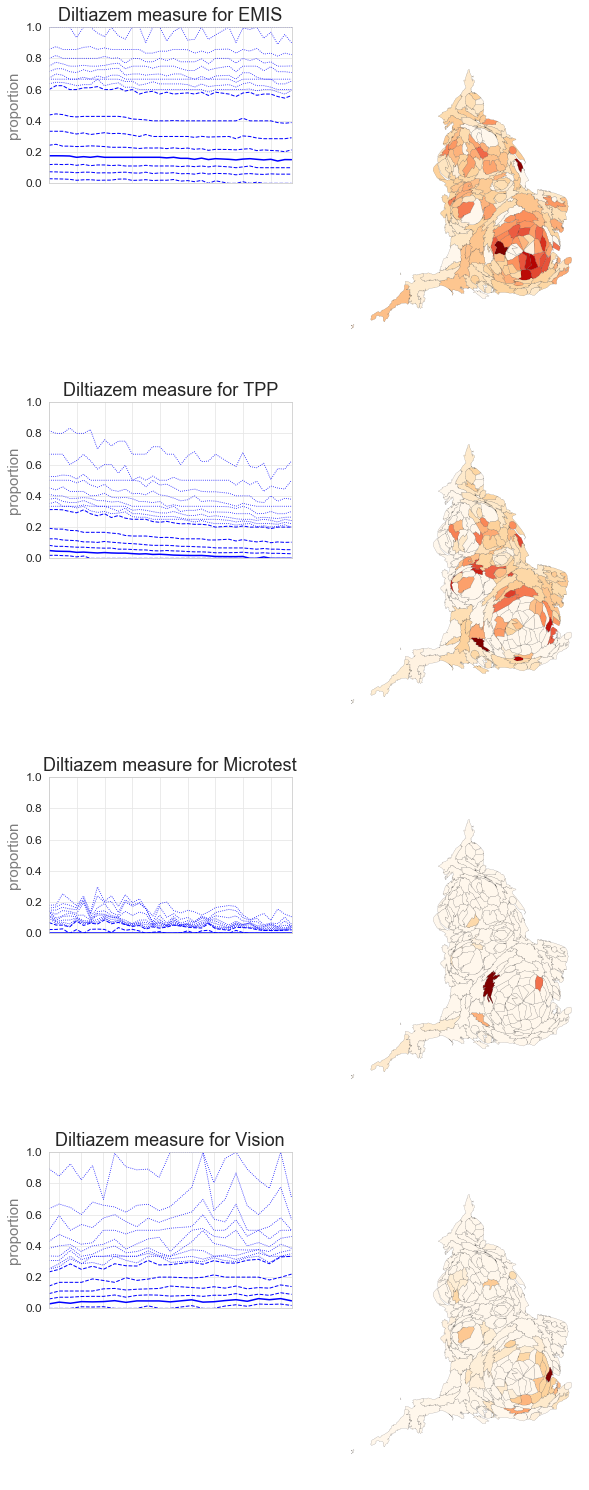

In [145]:


plt.figure(figsize=(20,30))
layout = gridspec.GridSpec(8, 4)
for i, supplier in enumerate(['EMIS', 'TPP', 'Microtest', 'Vision']):
    left_ax = plt.subplot(layout[i * 2, 0])
    right_subplot = layout[(i * 2):(i * 2 + 2), 1]
    #print("right subplot layout[%s]" % (2 - i % 2))
    #print("left ax layout[%s:%s, 0]" % ((i * 2), (i * 2 + 2)))
    #continue
    charts.deciles_chart(
        df[df['supplier'] == supplier],
        period_column='month',
        column='calc_value',
        title="Diltiazem measure for {}".format(supplier),
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=False,
        ax=left_ax
    )
    left_ax.set_ylim([0, 1])
    maps.ccg_map(
        by_supplier_and_pct[by_supplier_and_pct['supplier'] == supplier], 
        column='calc_value', 
        show_legend=False,
        cartogram=True, 
        subplot_spec=right_subplot)
plt.show()

## What do CCGs with a 50/50 emis/tpp split look like?

In [153]:
single_month = df[df['month'] == end]

In [154]:
by_pct_and_supplier = single_month.groupby(['pct', 'supplier']).count().reset_index()
by_pct = single_month.groupby(['pct']).count().reset_index()

In [155]:
# Create a list of CCGs in which between them TPP and EMIS roughly equally dominate the market
both = by_pct_and_supplier.merge(by_pct, how='inner', left_on='pct', right_on='pct')
both['proportion'] = both['practice_id_x'] / both['practice_id_y']
proportions = both[['pct', 'supplier_x', 'proportion']]
interesting_pcts = []
for key, rows in proportions.groupby('pct'):
    emis = tpp = None
    for i, row in rows.iterrows():
        if row['supplier_x'] == 'EMIS':
            emis = row['proportion']
        elif row['supplier_x'] == 'TPP':
            tpp = row['proportion']
    if emis is not None and tpp is not None:
        if emis > 0.4 and tpp > 0.4 and abs(emis - tpp) > fuzz:
            interesting_pcts.append(key)

In [170]:
qwe = pd.DataFrame(interesting_pcts)
qwe['interesting'] = 100
qwe.columns = ['pct', 'interesting']

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


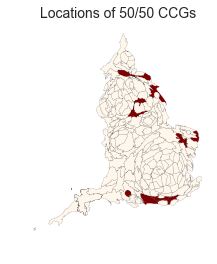

In [177]:
plt.figure(figsize=(6,4))
qwe = pd.concat([qwe, pd.DataFrame([{'pct': '99P', 'interesting': 0}])])
maps.ccg_map(
        qwe, 
        column='interesting', 
        show_legend=False,
        title='Locations of 50/50 CCGs',
        cartogram=True)
plt.show()

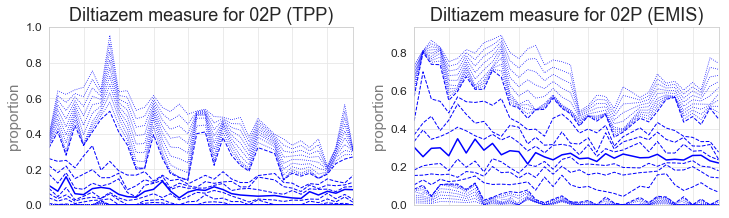

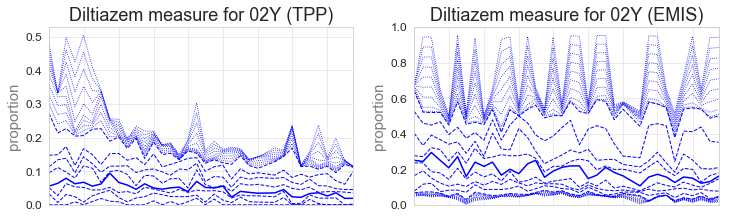

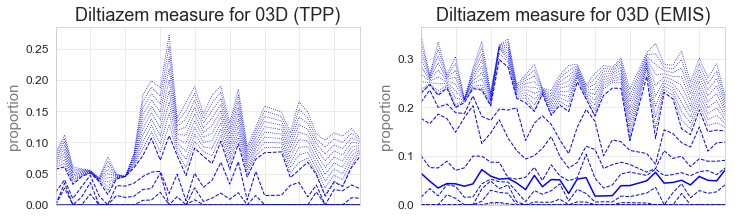

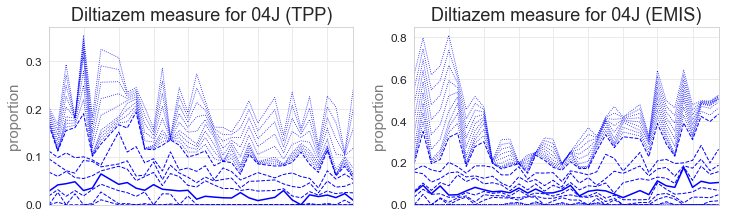

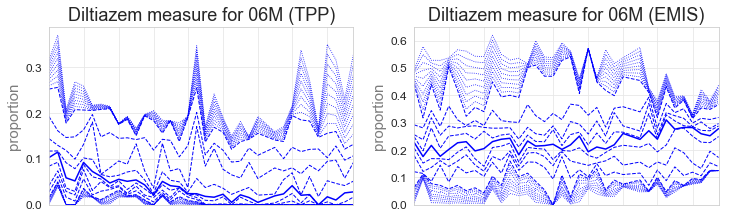

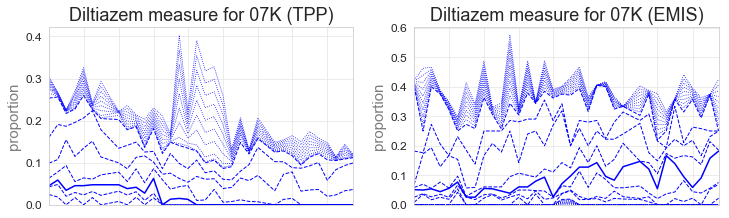

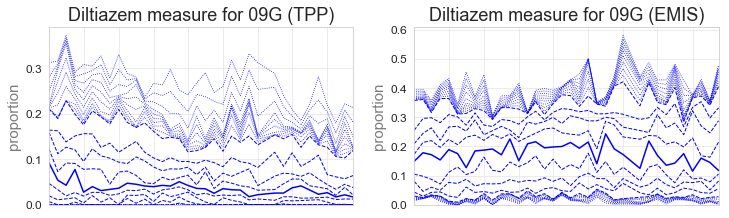

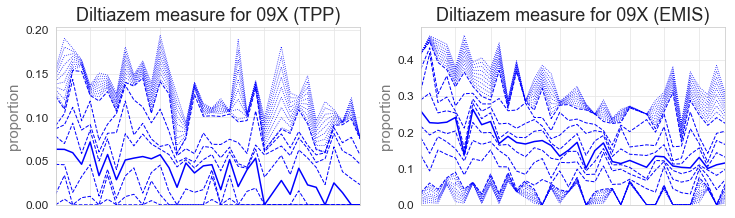

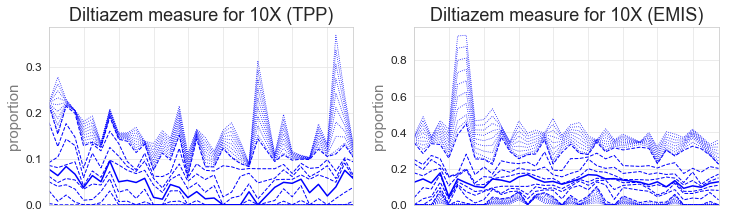

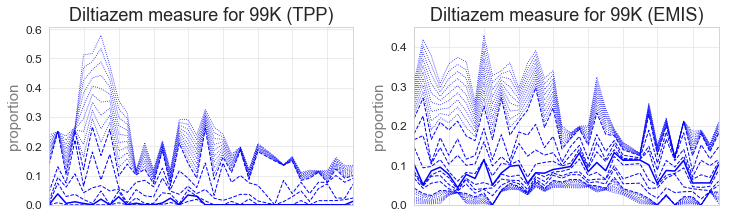

In [156]:
# Plot them side-by-side
for ccg in interesting_pcts:
    plt.figure(figsize=(12,8))
    layout = gridspec.GridSpec(2, 2)
    for cell, supplier in enumerate(['TPP', 'EMIS']):
        charts.deciles_chart(
            df[(df['supplier'] == supplier) & (df['pct'] == ccg)],
            period_column='month',
            column='calc_value',
            title="Diltiazem measure for {} ({})".format(ccg, supplier),
            ylabel="proportion",
            show_outer_percentiles=True,
            show_legend=False,
            ax=plt.subplot(layout[cell])
        )
    plt.show()

## Finding practices that swap

In [14]:
two_dates = vendors[(vendors.Date == '2017-01-01') | (vendors.Date == '2018-12-01')]

In [46]:
two_dates.groupby(['ODS', 'Principal Supplier', 'Date'])['Principal Supplier'].count().head(20)

ODS     Principal Supplier  Date      
A81001  TPP                 2017-01-01    1
                            2018-12-01    1
A81002  TPP                 2017-01-01    1
                            2018-12-01    1
A81004  TPP                 2017-01-01    1
                            2018-12-01    1
A81005  TPP                 2017-01-01    1
                            2018-12-01    1
A81006  TPP                 2017-01-01    1
                            2018-12-01    1
A81007  EMIS                2017-01-01    1
                            2018-12-01    1
A81008  TPP                 2017-01-01    1
A81009  TPP                 2017-01-01    1
                            2018-12-01    1
A81011  TPP                 2017-01-01    1
                            2018-12-01    1
A81012  TPP                 2017-01-01    1
                            2018-12-01    1
A81013  TPP                 2017-01-01    1
Name: Principal Supplier, dtype: int64

In [59]:
changes = two_dates.groupby(
    ['ODS', 'Principal Supplier', 'Date'])['Principal Supplier'].count().unstack().unstack()
changes.head()

Date               2017-01-01                       2018-12-01                 \
Principal Supplier       EMIS Microtest  TPP Vision       EMIS Microtest  TPP   
ODS                                                                             
A81001                    NaN       NaN  1.0    NaN        NaN       NaN  1.0   
A81002                    NaN       NaN  1.0    NaN        NaN       NaN  1.0   
A81004                    NaN       NaN  1.0    NaN        NaN       NaN  1.0   
A81005                    NaN       NaN  1.0    NaN        NaN       NaN  1.0   
A81006                    NaN       NaN  1.0    NaN        NaN       NaN  1.0   

Date                       
Principal Supplier Vision  
ODS                        
A81001                NaN  
A81002                NaN  
A81004                NaN  
A81005                NaN  
A81006                NaN

In [164]:
change_dates = pd.DataFrame(vendors.groupby(['ODS', 'Principal Supplier'])['Date'].max()).groupby('ODS')['Date'].min()

In [75]:
import numpy as np
def from_vendor(df, vendor):
    no_longer = df[(df['2017-01-01', vendor] == 1.0) & (df['2018-12-01', vendor] != 1.0)]
    still = no_longer[~(np.isnan(no_longer['2018-12-01', 'EMIS'])&np.isnan(no_longer['2018-12-01', 'TPP'])&np.isnan(no_longer['2018-12-01', 'Vision']))]
    vendors[vendors['ODS'] == ]
    still['switch_date'] = # last date we see vendor for 
    return still
from_tpp = from_vendor(changes, 'TPP')
from_emis = from_vendor(changes, 'EMIS')
from_vision = from_vendor(changes, 'Vision')
from_microtest = from_vendor(changes, 'Microtest')

In [143]:
from_emis.head()

Date               2017-01-01                      2018-12-01                 \
Principal Supplier       EMIS Microtest TPP Vision       EMIS Microtest  TPP   
ODS                                                                            
A81015                    1.0       NaN NaN    NaN        NaN       NaN  1.0   
A83014                    1.0       NaN NaN    NaN        NaN       NaN  1.0   
A83635                    1.0       NaN NaN    NaN        NaN       NaN  1.0   
A83637                    1.0       NaN NaN    NaN        NaN       NaN  1.0   
A84002                    1.0       NaN NaN    NaN        NaN       NaN  1.0   

Date                       
Principal Supplier Vision  
ODS                        
A81015                NaN  
A83014                NaN  
A83635                NaN  
A83637                NaN  
A84002                NaN

In [84]:
from_emis.count()

Date        Principal Supplier
2017-01-01  EMIS                  122
            Microtest               0
            TPP                     0
            Vision                  0
2018-12-01  EMIS                    0
            Microtest               0
            TPP                   121
            Vision                  1
dtype: int64

In [85]:
from_tpp.count()

Date        Principal Supplier
2017-01-01  EMIS                   0
            Microtest              0
            TPP                   32
            Vision                 0
2018-12-01  EMIS                  32
            Microtest              0
            TPP                    0
            Vision                 0
dtype: int64

In [86]:
# Create two groups of equal size (should really match to population number too)
tpp_to_emis = from_tpp[from_tpp['2018-12-01', 'EMIS'] == 1.0]
emis_to_tpp = from_emis[from_emis['2018-12-01', 'TPP'] == 1.0].sample(n=32)

In [119]:
to_emis_data = tpp_to_emis.reset_index().merge(df, how='inner', left_on='ODS', right_on='practice_id')
to_tpp_data = emis_to_tpp.reset_index().merge(df, how='inner', left_on='ODS', right_on='practice_id')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


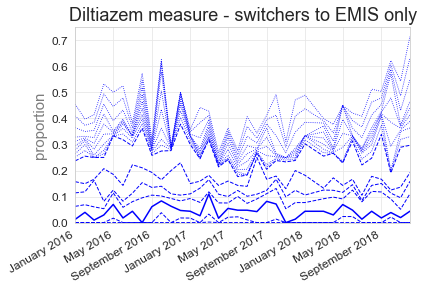

In [118]:
charts.deciles_chart(
        to_emis_data,
        period_column='month',
        column='calc_value',
        title="Diltiazem measure - switchers to EMIS only",
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=False
    )
plt.show()


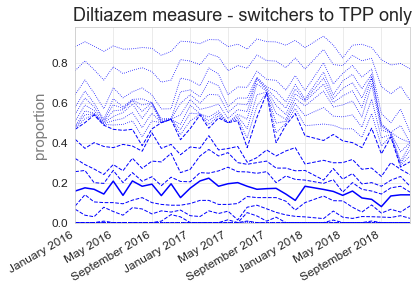

In [120]:
charts.deciles_chart(
        to_tpp_data,
        period_column='month',
        column='calc_value',
        title="Diltiazem measure - switchers to TPP only",
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=False
    )
plt.show()


In [136]:
to_tpp_data[to_tpp_data['month'] == start]['calc_value'].describe()

count    31.000000
mean      0.217967
std       0.230960
min       0.000000
25%       0.026481
50%       0.157895
75%       0.331446
max       1.000000
Name: calc_value, dtype: float64

In [130]:
to_tpp_data[to_tpp_data['month'] == end]['calc_value'].describe()

count    31.000000
mean      0.152609
std       0.186675
min       0.000000
25%       0.000000
50%       0.138889
75%       0.200000
max       0.927536
Name: calc_value, dtype: float64

In [137]:
to_emis_data[to_emis_data['month'] == start]['calc_value'].describe()

count    28.000000
mean      0.084189
std       0.124503
min       0.000000
25%       0.000000
50%       0.012500
75%       0.129464
max       0.500000
Name: calc_value, dtype: float64

In [138]:
to_emis_data[to_emis_data['month'] == end]['calc_value'].describe()

count    26.000000
mean      0.121754
std       0.185043
min       0.000000
25%       0.000000
50%       0.043907
75%       0.184524
max       0.800000
Name: calc_value, dtype: float64

In [170]:
change_dates['A81001']

'2018-12-01'

Switchers to TPP


/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


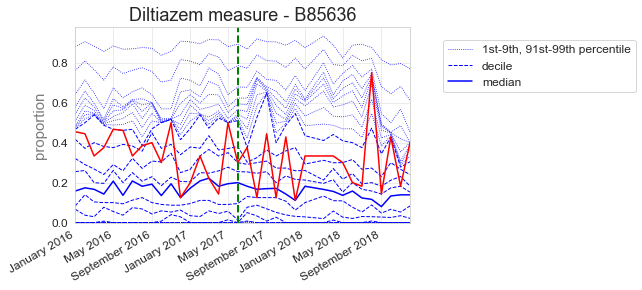

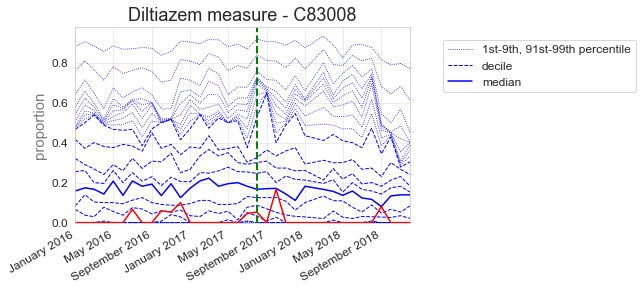

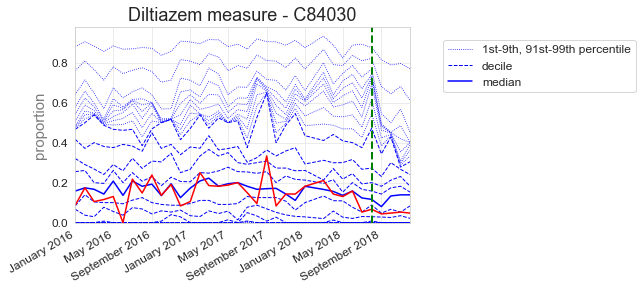

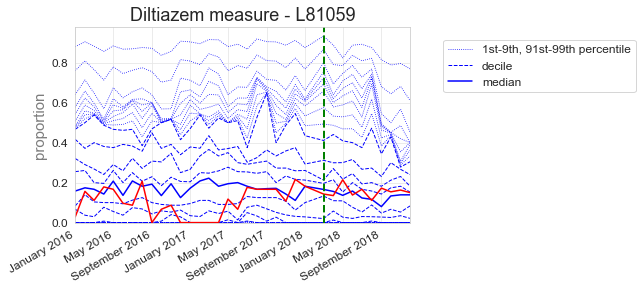

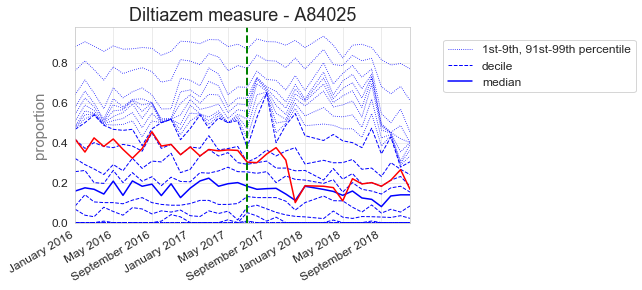

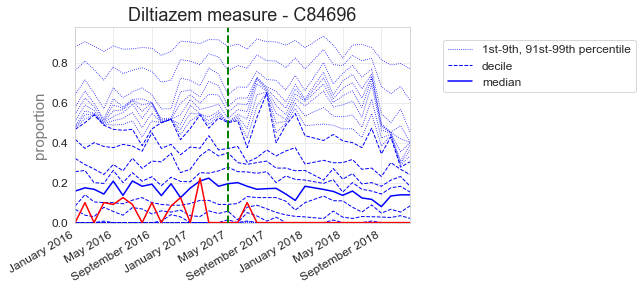

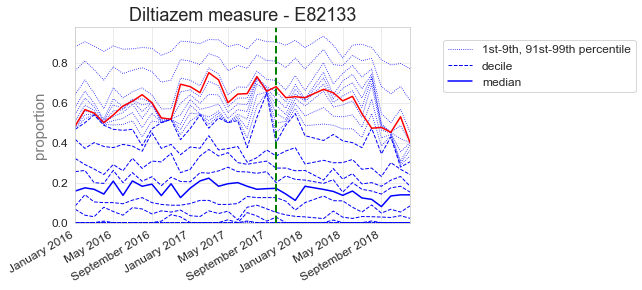

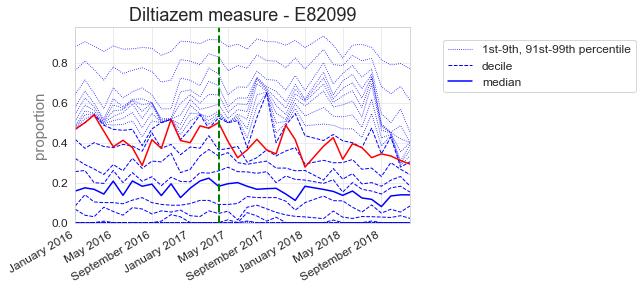

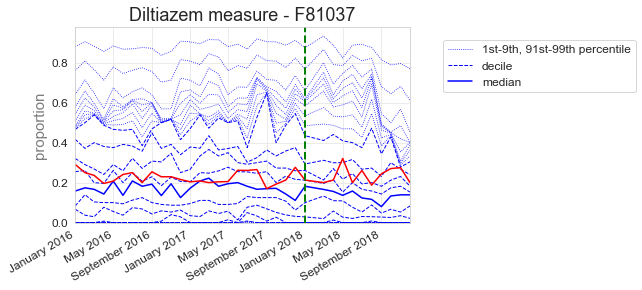

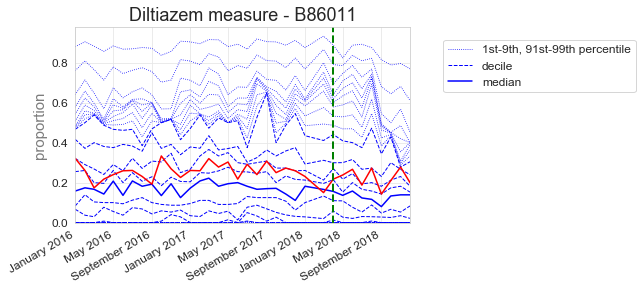

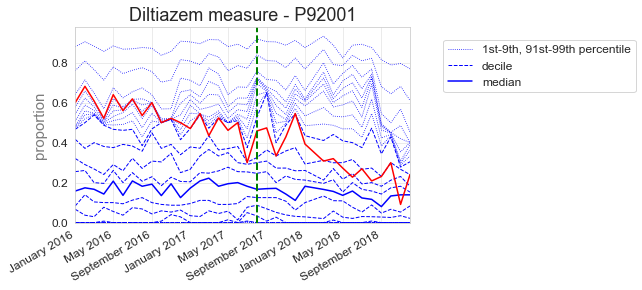

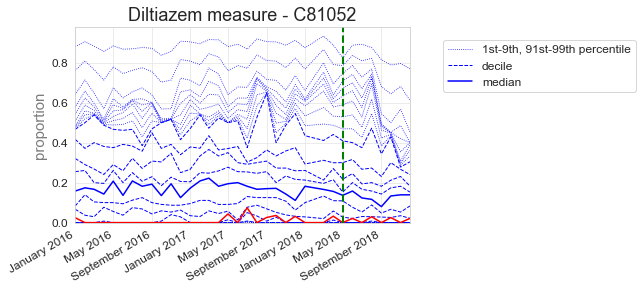

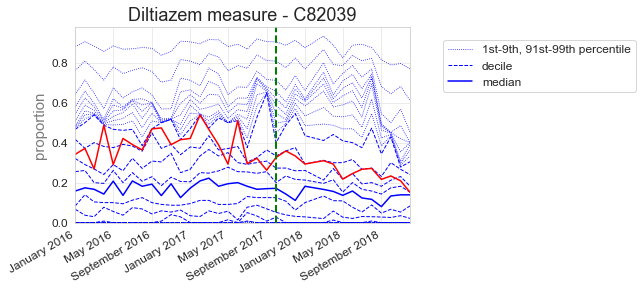

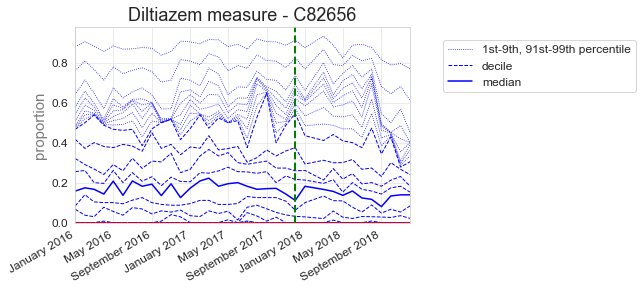

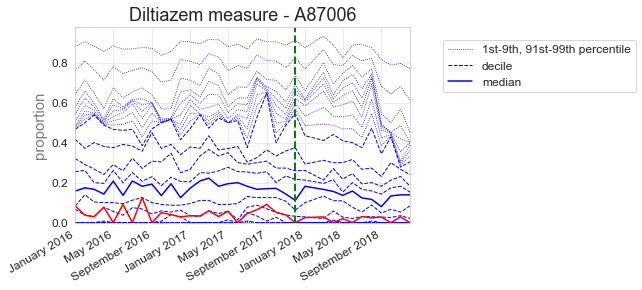

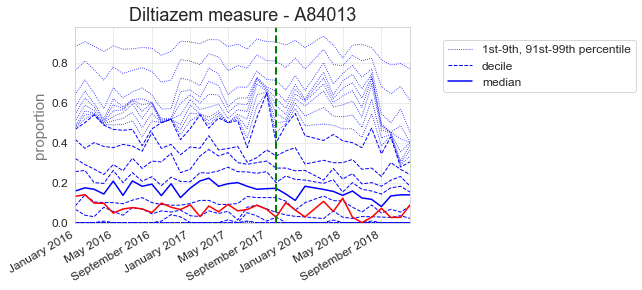

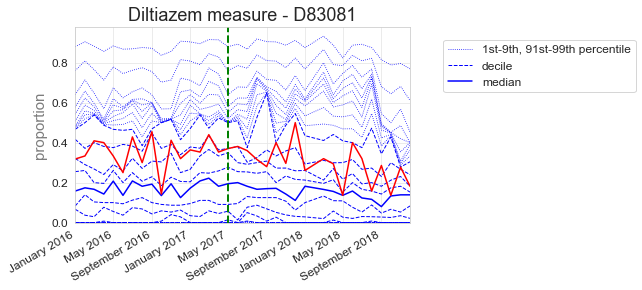

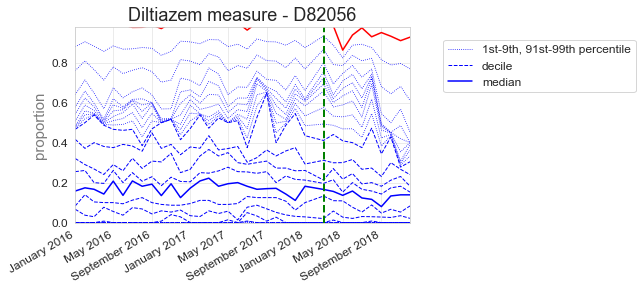

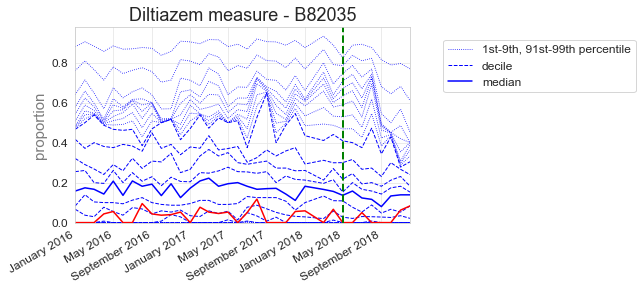

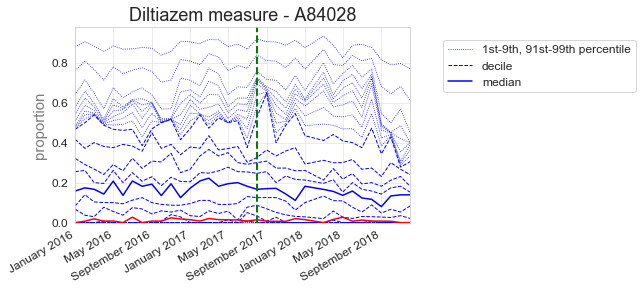

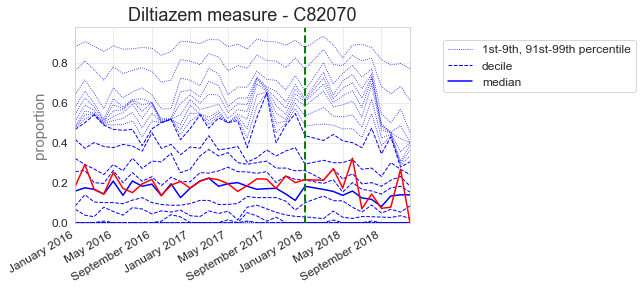

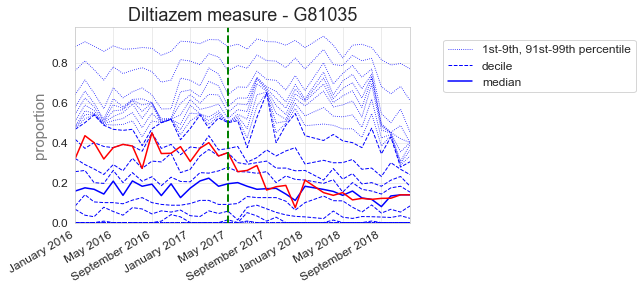

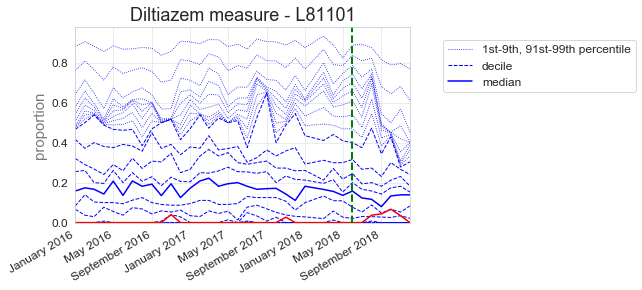

In [172]:
print ("Switchers to TPP")
for practice_id in to_tpp_data.practice_id.unique():
    _, ax = plt.subplots()
    charts.deciles_chart(
        to_tpp_data,
        period_column='month',
        column='calc_value',
        title="Diltiazem measure - {}".format(practice_id),
        ylabel="proportion",
        show_outer_percentiles=True,
        ax=ax)
    
    practice_data = to_tpp_data[to_tpp_data['practice_id'] == practice_id]
    plt.plot(practice_data['month'], practice_data['calc_value'], 'r-')
    ax.axvline(pd.to_datetime(change_dates[practice_id]), color='g', linestyle='--', lw=2)


Switchers to EMIS


/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


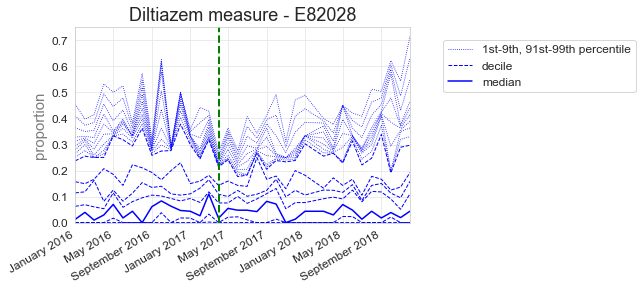

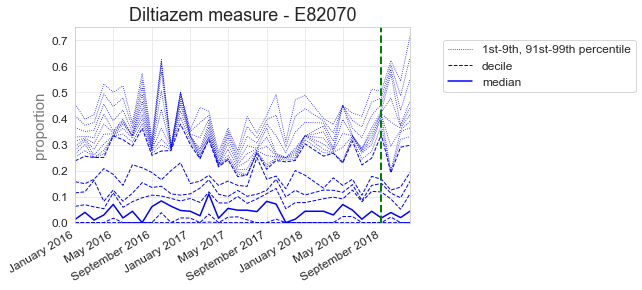

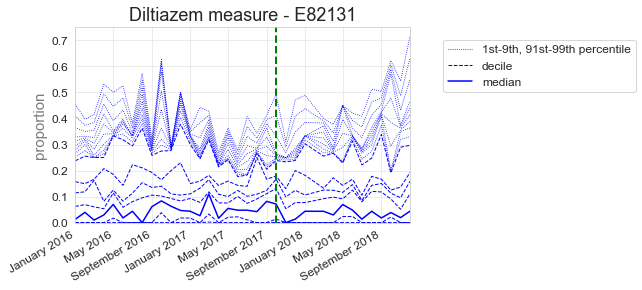

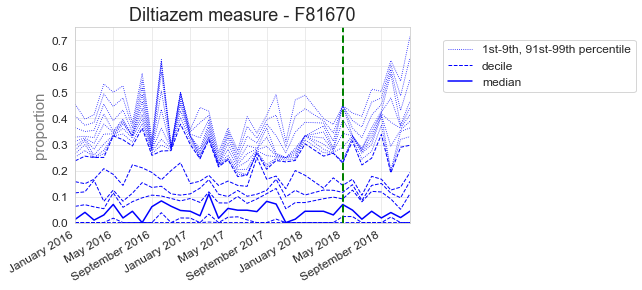

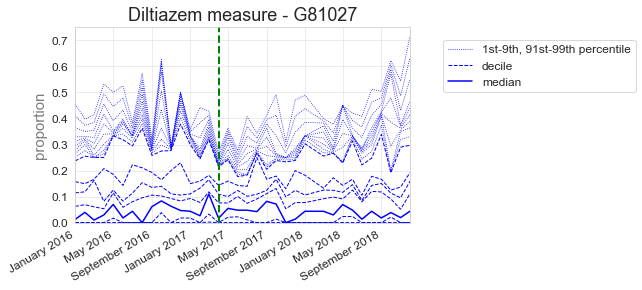

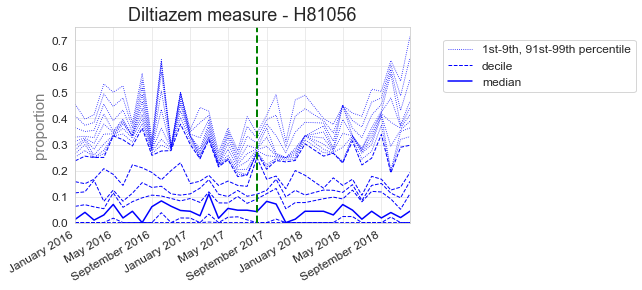

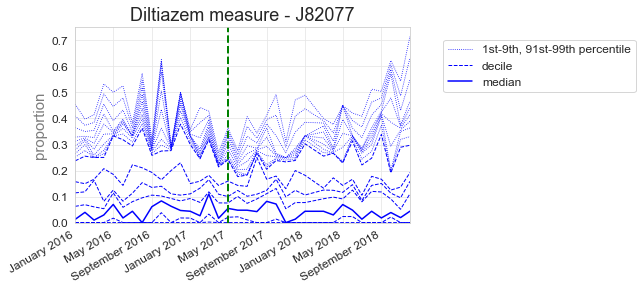

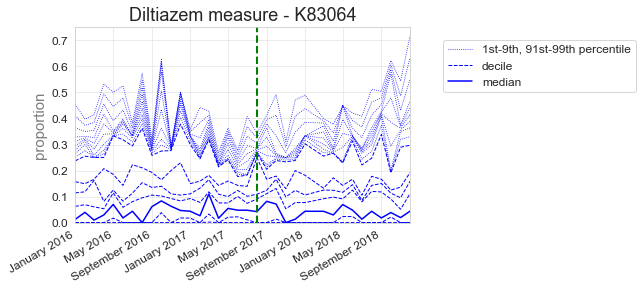

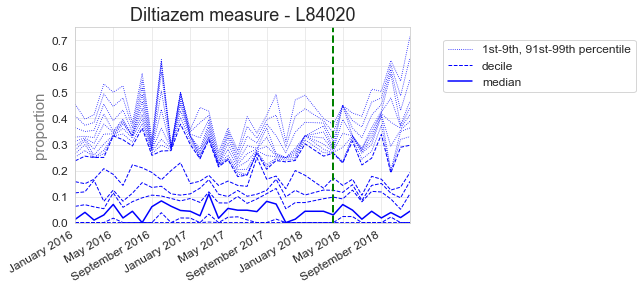

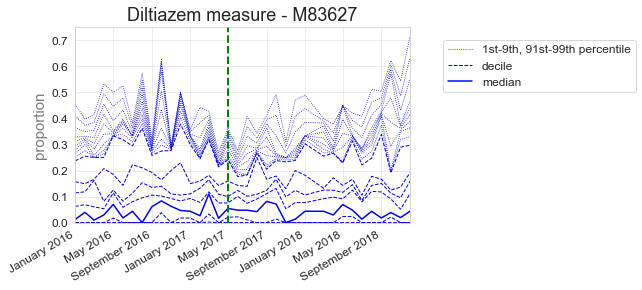

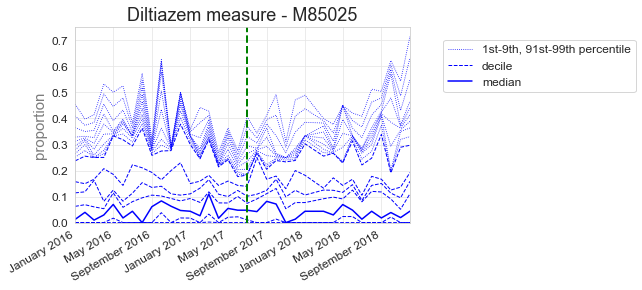

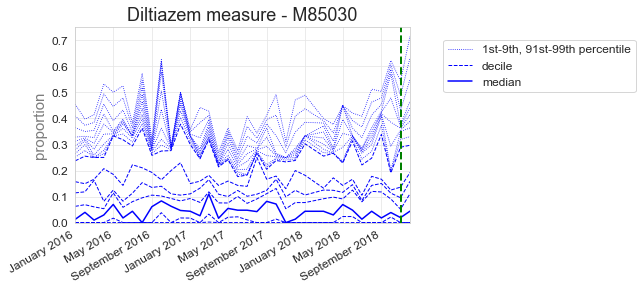

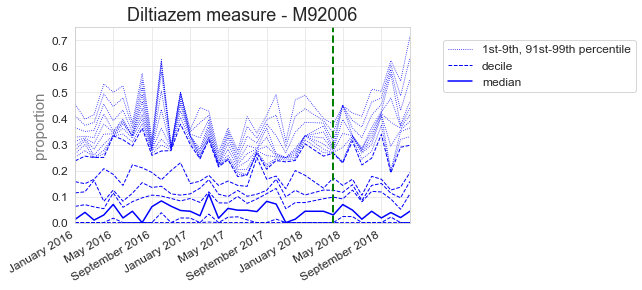

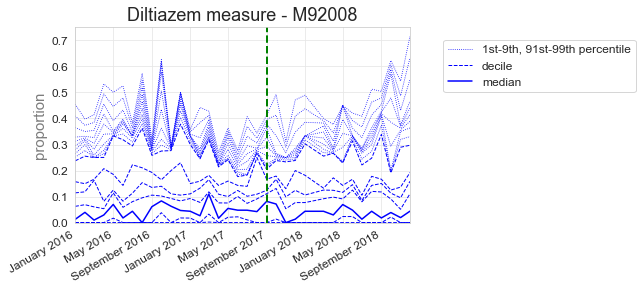

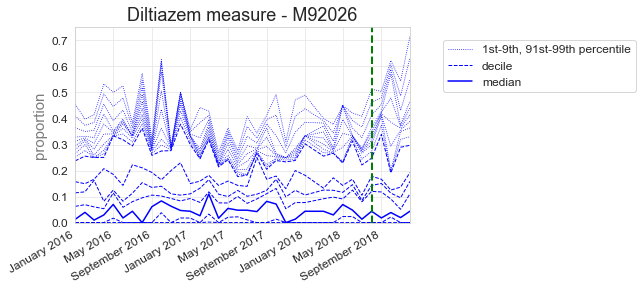

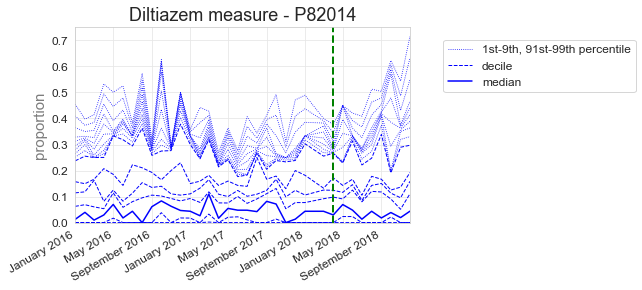

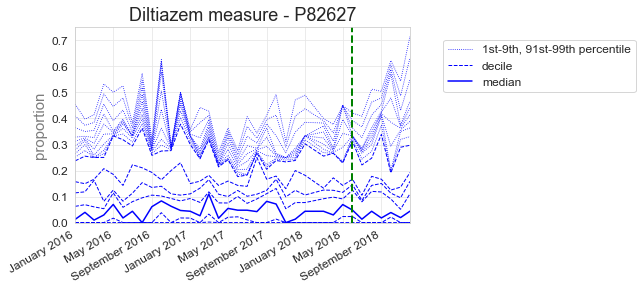

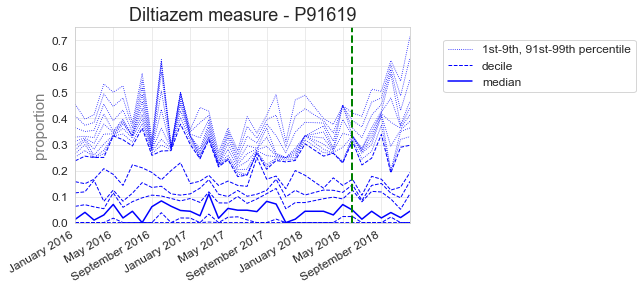

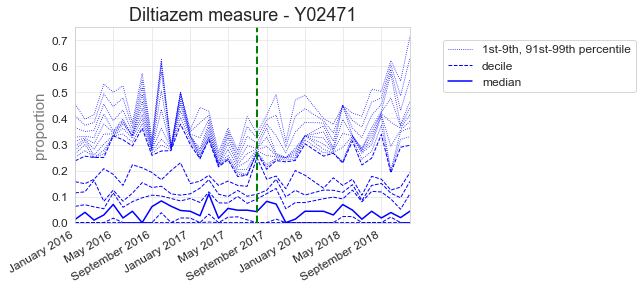

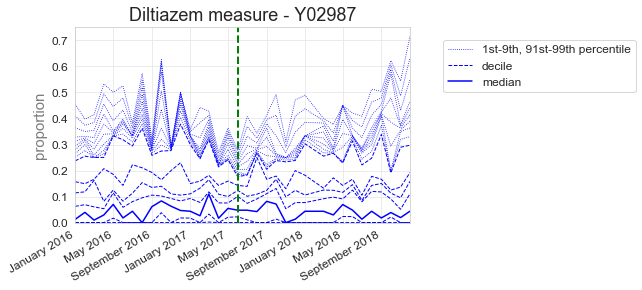

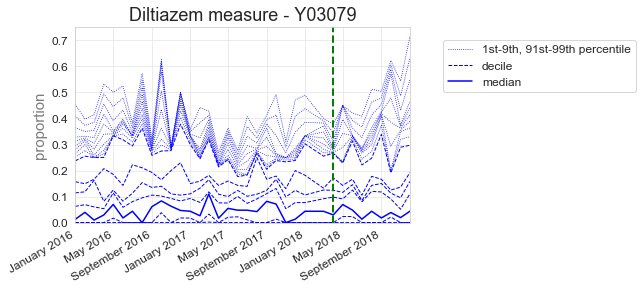

In [173]:
print ("Switchers to EMIS")
for practice_id in to_emis_data.practice_id.unique():
    _, ax = plt.subplots()
    charts.deciles_chart(
        to_emis_data,
        period_column='month',
        column='calc_value',
        title="Diltiazem measure - {}".format(practice_id),
        ylabel="proportion",
        show_outer_percentiles=True,
        ax=ax)
    
    practice_data = to_tpp_data[to_tpp_data['practice_id'] == practice_id]
    plt.plot(practice_data['month'], practice_data['calc_value'], 'r-')
    ax.axvline(pd.to_datetime(change_dates[practice_id]), color='g', linestyle='--', lw=2)
